In [365]:
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from math import ceil, floor
from skimage.feature import corner_harris, corner_peaks, peak_local_max
from scipy.spatial.distance import cdist


In [366]:
SAMPLE_NUMBER = 2
image_dir = Path.cwd()/"samples"/str(SAMPLE_NUMBER)
IMAGES = [x for x in image_dir.iterdir() if x.suffix == ".jpg"]

In [367]:
im1 = cv2.imread(str(IMAGES[0]))
im2 = cv2.imread(str(IMAGES[1]))

In [368]:
def get_points(im, n = 1_000):
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    h = corner_harris(im_gray)
    coords = peak_local_max(h, min_distance=5, threshold_rel=0.001, exclude_border=30)
    print(len(coords))
    # if len(coords) > 5_000:
    # return coords

    dist = cdist(coords, coords)
    c_robust = 0.9
    strength = h[coords[:,0], coords[:,1]]
    ver = np.tile(strength, (strength.shape[0], 1))
    hor = np.transpose(ver)
    mask = (ver < c_robust*hor)
    INF = 100000000
    dist[~mask] = INF
    minimum_distance = np.min(dist, axis=1)
    # sort indices by the minimum distance
    sorted_indices = np.argsort(minimum_distance)
    sorted_indices = sorted_indices[::-1]
    trimmed = sorted_indices[:n]
    coords = coords[trimmed]
    return coords

In [369]:
pts1 = get_points(im1)

846


In [370]:
pts2 = get_points(im2)

3246


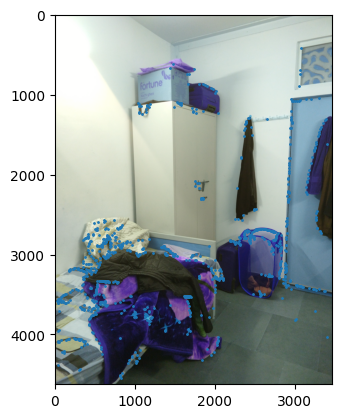

In [371]:
plt.imshow(im1)
plt.scatter(pts1[:,1], pts1[:,0], s=1)

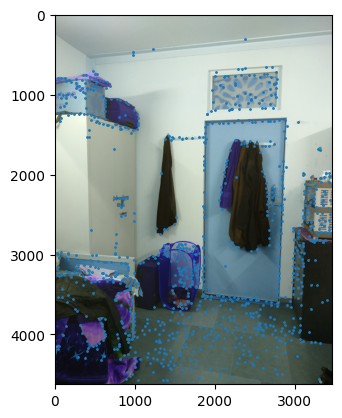

In [372]:
plt.imshow(im2)
plt.scatter(pts2[:,1], pts2[:,0], s=1)

In [373]:
def get_patches(im, pts):
    ps = 20
    patches = []
    for pt in pts:
        x, y = pt[0], pt[1]
        patch = im[x-ps:x+ps, y-ps:y+ps]
        patch = (patch - np.mean(patch))/np.std(patch)
        patch = cv2.resize(patch, (8, 8))

        
        patch = patch.flatten()
        patches.append(patch)
    patches = np.array(patches)
    return patches

In [374]:
patch1 = get_patches(im1, pts1)
patch2 = get_patches(im2, pts2)
correspondence = cdist(patch1, patch2, metric='sqeuclidean')

smallest_index = np.argmin(correspondence, axis = 1)
smallest_values = correspondence[np.arange(correspondence.shape[0]), smallest_index]
correspondence[:, smallest_index] = 10000000000
second_smallest_index = np.argmin(correspondence, axis = 1)
mapping = {}
for i in range(len(smallest_index)):
    a = smallest_values[i]
    b = correspondence[i, second_smallest_index[i]]
    ratio = a/b
    if ratio < 0.4:
        mapping[i] = smallest_index[i]
print(len(mapping))

71


In [375]:
matched1 = []
matched2 = []
s1 = set()
for i, j in mapping.items():
    if j in s1:
        continue
    s1.add(j)
    x,y = pts1[i]
    matched1.append([x,y])
    x,y = pts2[j]
    matched2.append([x,y])
matched1 = np.array(matched1)
matched2 = np.array(matched2)

In [376]:
from skimage.feature import plot_matches

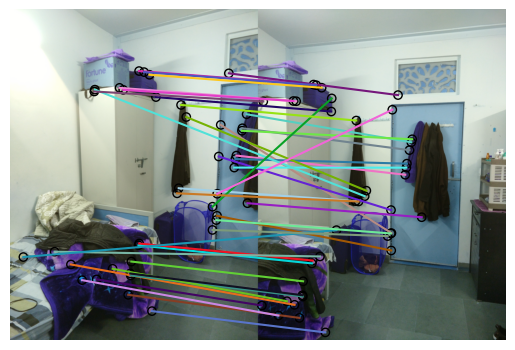

In [377]:
# plot the mappings on the images
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.axis('off')
plot_matches(ax, im1, im2, matched1, matched2, np.array([(i, i) for i in range(len(matched1))]))
plt.savefig("matches.png", bbox_inches='tight', pad_inches=0)

In [386]:
def solver(COORDS):
    '''
    COORDS : Nx2x2 array of coordinates
    x', y' = COORDS[i][0]
    x, y = COORDS[i][1]
    '''
    n, _, _ = COORDS.shape
    A = []
    B = []
    for i in range(n):
        x_, y_ = COORDS[i][0]
        x, y = COORDS[i][1]
        
        a = np.array([
            [x,y,1,0,0,0,-x*x_,-y*x_],
            [0,0,0,x,y,1,-x*y_,-y*y_]
        ])
        b = np.array([x_, y_])
        A.append(a)
        B.append(b)

    A = np.vstack(A)
    B = np.hstack(B)
    
    H = np.linalg.lstsq(A, B, rcond=None)[0]
    H = np.append(H, 1)
    H.resize((3,3))
    return H

In [387]:
def RANSAC(pts1, pts2, n = 5000, threshold = 20):
    best = 0
    best_model = None
    pt1_xy1 = np.vstack([pts1[:,1], pts1[:,0], np.ones(pts1.shape[0])])
    pt2_xy1 = np.vstack([pts2[:,1], pts2[:,0], np.ones(pts2.shape[0])])

    for i in range(n):
        # pick 4 points at random
        indices = np.random.choice(np.arange(len(pts1)), 4, replace=False)
        p1 = pts1[indices]
        p2 = pts2[indices]
        # compute homography
        coords = []
        for i in range(4):
            y, x = p1[i]
            y_, x_ = p2[i]
            coords.append([[x, y], [x_, y_]])
        coords = np.array(coords)
        H = solver(coords)
        transformed_all = H @ pt2_xy1
        transformed_all /= transformed_all[2]
        # apply homography to all points
        # compute inliers
        dist = np.linalg.norm(pt1_xy1 - transformed_all, axis=0)
        inliers = np.sum(dist < threshold)
        if inliers > best:
            best = inliers
            best_model = H
    
    print(best)
    return best_model

In [388]:
H = RANSAC(matched1, matched2)

13


In [389]:
def get_bounding_box(image, H):
    # get all corners
    corners = np.array([
        [0, 0, 1],
        [image.shape[1], 0, 1],
        [0, image.shape[0], 1],
        [image.shape[1], image.shape[0], 1],
    ]).T

    # transform corners
    corners = H @ corners

    # normalize: x/w, y/w
    corners = corners / corners[2]

    # get bounding box
    min_x = floor(np.min(corners[0]))
    max_x = ceil(np.max(corners[0]))
    min_y = floor(np.min(corners[1]))
    max_y = ceil(np.max(corners[1]))
    
    return (min_x, max_x, min_y, max_y)

def get_translation_matrix(deltax, deltay):
    return np.array([
        [1, 0, deltax],
        [0, 1, deltay],
        [0, 0, 1]
    ], dtype=np.float32)

def merge(image_homographies_pairs):
    # homographies are with respect to the origin of the first image
    X, Y = float('inf'), float('inf')
    Xprime, Yprime = float('-inf'), float('-inf')
    for image, H in image_homographies_pairs:
        min_x, max_x, min_y, max_y = get_bounding_box(image, H)
        X = min(X, min_x)
        Y = min(Y, min_y)
        Xprime = max(Xprime, max_x)
        Yprime = max(Yprime, max_y)

    canvas_size = (Xprime - X, Yprime - Y)
    images = []
    for image, H in image_homographies_pairs:
        deltax = -X
        deltay = -Y
        translation_matrix = get_translation_matrix(deltax, deltay)
        warped = cv2.warpPerspective(image, translation_matrix @ H, canvas_size)
        images.append(warped)
    return images

In [390]:
im1 = cv2.imread(str(IMAGES[0]))
im2 = cv2.imread(str(IMAGES[1]))
ims = [(im1, np.eye(3)), (im2, H)]
im1, im2 = merge(ims)


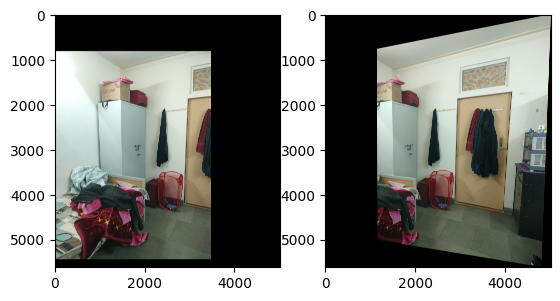

In [391]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

In [392]:
im1_mask = np.any(im1 != [0, 0, 0], axis=2)
im2_mask = np.any(im2 != [0, 0, 0], axis=2)
common = np.logical_and(im1_mask, im2_mask)
common_image = cv2.addWeighted(im1, 0.5, im2, 0.5, 0)
final_image = im1 + im2
final_image[common] = common_image[common]

cv2.imwrite(str(image_dir/'output.jpg'), final_image)

True

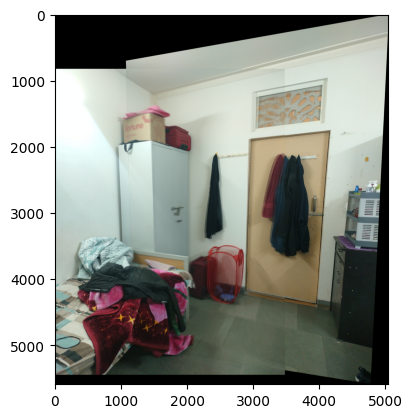

In [385]:
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))